# S&P 500 Stock Removal Prediction

This notebook demonstrates the machine learning workflow for predicting stock removals from the S&P 500 index.

## Overview

The analysis includes:
1. Data loading and exploration
2. Feature analysis and visualization
3. Model training and hyperparameter tuning
4. Model evaluation and comparison
5. Feature importance analysis

## Setup

First, let's import the necessary modules and set up our environment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom modules
from src.models.train import (
    create_preprocessing_pipeline,
    split_data,
    train_model,
    tune_model,
    get_default_param_grids
)
from src.models.evaluate import evaluate_model, analyze_feature_importance, compare_models
from src.models.visualization import (
    plot_feature_distributions,
    plot_correlation_matrix,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importance
)

# Import scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 1. Data Loading and Initial Exploration

Load the processed dataset and examine its structure.

In [2]:
# Load the processed dataset
data = pd.read_csv('data/processed/aggregated_stock_features.csv')

In [3]:
# Display number of rows and columns
print("Dataset Shape:")
print(data.shape)

Dataset Shape:
(948, 17)


In [4]:
# Display column data types and number of non-null values
print("\nColumn Information:\n")
print(data.info())


Column Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Ticker                     948 non-null    object 
 1   Latest_Price               948 non-null    float64
 2   Latest_Volume              948 non-null    int64  
 3   Latest_Est_Market_Cap      948 non-null    float64
 4   Last_Week_Price_Change     948 non-null    float64
 5   Last_Week_Average          948 non-null    float64
 6   Last_Week_Volatility       948 non-null    float64
 7   Last_Month_Price_Change    948 non-null    float64
 8   Last_Month_Average         948 non-null    float64
 9   Last_Month_Volatility      948 non-null    float64
 10  Last_3Months_Price_Change  948 non-null    float64
 11  Last_3Months_Average       948 non-null    float64
 12  Last_3Months_Volatility    948 non-null    float64
 13  Total_Return               9

In [5]:
# Display summary statistics for numeric columns such as mean, std, min, max, etc.
print("\nSummary Statistics:\n")
print(data.describe())


Summary Statistics:

       Latest_Price  Latest_Volume  Latest_Est_Market_Cap  \
count    948.000000   9.480000e+02           9.480000e+02   
mean      56.561118   1.203459e+07           3.416846e+08   
std       64.416162   2.311495e+07           5.606696e+08   
min        2.127682   1.560000e+04           8.858115e+04   
25%       15.490000   9.378000e+05           4.299190e+07   
50%       32.478992   3.411436e+06           1.246087e+08   
75%       68.760002   1.282340e+07           4.294420e+08   
max      380.141632   2.813697e+08           7.295358e+09   

       Last_Week_Price_Change  Last_Week_Average  Last_Week_Volatility  \
count              948.000000         948.000000            948.000000   
mean                -0.008650          57.089348              0.017397   
std                  0.040821          65.018181              0.013549   
min                 -0.212384           2.130736              0.001113   
25%                 -0.028459          15.310000          

## 2. Feature Analysis and Visualization

Analyze the features and their distributions to understand the data better

<Figure size 2000x1000 with 0 Axes>

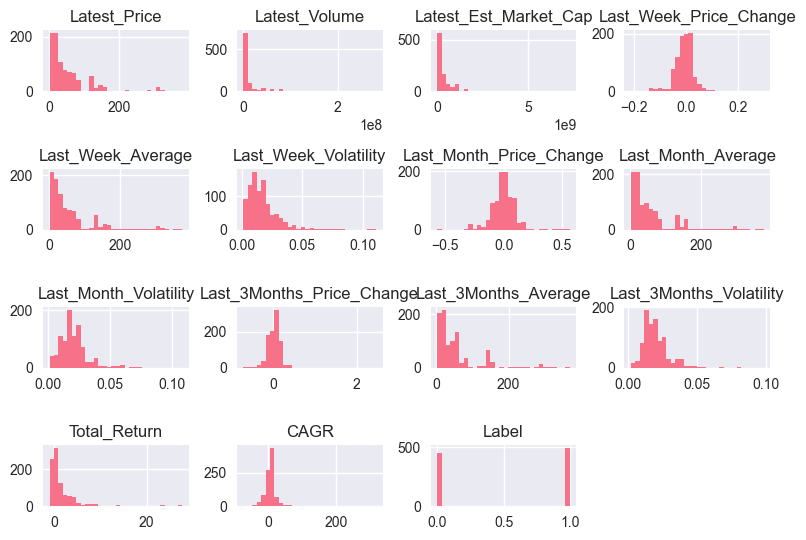

In [6]:
# Identify numeric features
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns

# Plot feature distributions
plot_feature_distributions(data, numeric_features)

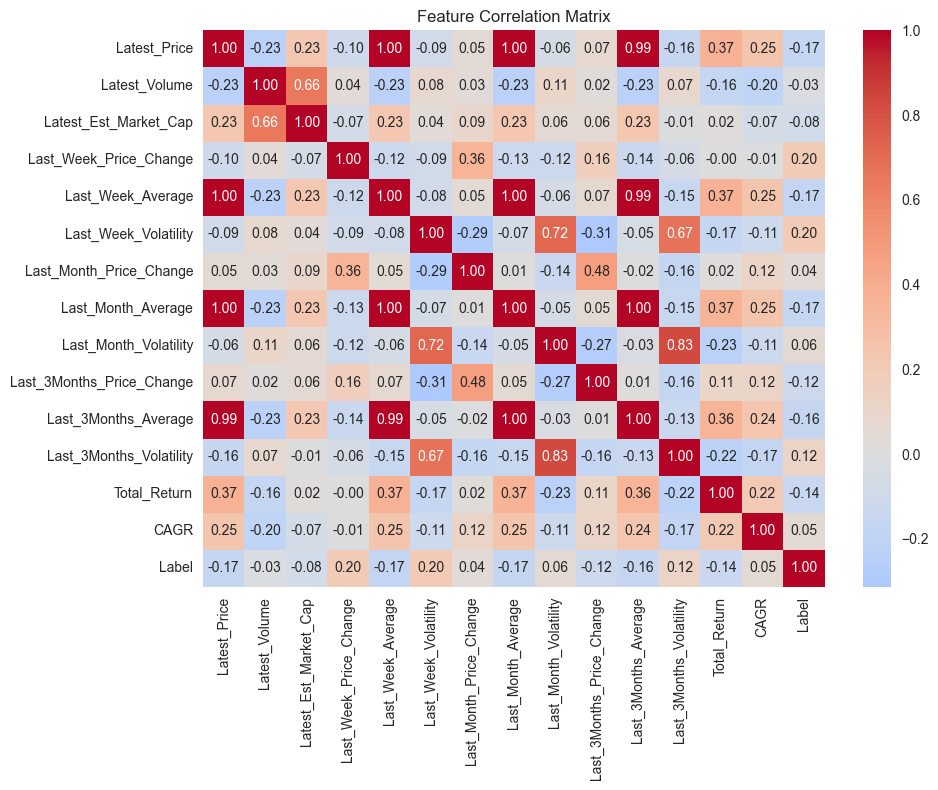

In [7]:
# Plot correlation matrix
plot_correlation_matrix(data[numeric_features])

In [11]:
# Print class distribution
print("\nClass Distribution:")
print(data['Label'].value_counts())


Class Distribution:
Label
1    493
0    455
Name: count, dtype: int64


## 3. Data Preparation

Prepare the data for model training by:
1. Separating features and target
2. Splitting into train, validation, and test sets
3. Creating preprocessing pipeline

In [8]:
# Separate features and target
target_column = 'Label'
X = data.drop(columns=[target_column, 'Ticker', 'End_date'])
y = data[target_column]

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
preprocessor = create_preprocessing_pipeline(numeric_features)

INFO:src.models.train:Training set shape: (663, 14)
INFO:src.models.train:Validation set shape: (142, 14)
INFO:src.models.train:Test set shape: (143, 14)


In [12]:
# Print class distribution for each set in a table
print("\nClass Distribution:")
print(pd.DataFrame({
    'Training Set': y_train.value_counts(),
    'Validation Set': y_val.value_counts(),
    'Test Set': y_test.value_counts()
}))


Class Distribution:
       Training Set  Validation Set  Test Set
Label                                        
1               345              74        74
0               318              68        69


## 4. Model Training and Tuning

Train and tune multiple models to compare their performance.

In [9]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Get parameter grids
param_grids = get_default_param_grids()

# Train and tune models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...\n")
    if name.lower().replace(' ', '_') in param_grids:
        # Tune model
        trained_model, best_params = tune_model(
            X_train, y_train, preprocessor, model,
            param_grids[name.lower().replace(' ', '_')]
        )
    else:
        # Train without tuning
        trained_model = train_model(X_train, y_train, preprocessor, model)
    
    trained_models[name] = trained_model

Training Logistic Regression...

Fitting 3 folds for each of 8 candidates, totalling 24 fits


INFO:src.models.train:Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
INFO:src.models.train:Best Score: 0.6877


Training SVM...

Fitting 3 folds for each of 40 candidates, totalling 120 fits


INFO:src.models.train:Best Parameters: {'classifier__C': 100, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
INFO:src.models.train:Best Score: 0.9562


Training Random Forest...

Fitting 3 folds for each of 108 candidates, totalling 324 fits


INFO:src.models.train:Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
INFO:src.models.train:Best Score: 0.9852


## 5. Model Evaluation

Evaluate the models and compare their performance.

In [10]:
# Compare models
model_comparison = compare_models(trained_models, X_val, y_val, X_test, y_test)
print("\nModel Comparison:\n")
display(model_comparison)

INFO:src.models.evaluate:
Validation Set Metrics:
INFO:src.models.evaluate:Accuracy: 0.7394
INFO:src.models.evaluate:Precision: 0.7761
INFO:src.models.evaluate:Recall: 0.7027
INFO:src.models.evaluate:F1 Score: 0.7376
INFO:src.models.evaluate:Auc: 0.7778
INFO:src.models.evaluate:
Test Set Metrics:
INFO:src.models.evaluate:Accuracy: 0.7483
INFO:src.models.evaluate:Precision: 0.7500
INFO:src.models.evaluate:Recall: 0.7703
INFO:src.models.evaluate:F1 Score: 0.7600
INFO:src.models.evaluate:Auc: 0.7894
INFO:src.models.evaluate:
Validation Set Metrics:
INFO:src.models.evaluate:Accuracy: 0.9577
INFO:src.models.evaluate:Precision: 0.9595
INFO:src.models.evaluate:Recall: 0.9595
INFO:src.models.evaluate:F1 Score: 0.9595
INFO:src.models.evaluate:Auc: 0.9932
INFO:src.models.evaluate:
Test Set Metrics:
INFO:src.models.evaluate:Accuracy: 0.9650
INFO:src.models.evaluate:Precision: 0.9600
INFO:src.models.evaluate:Recall: 0.9730
INFO:src.models.evaluate:F1 Score: 0.9664
INFO:src.models.evaluate:Auc: 0.9


Model Comparison:



,Model,Validation Accuracy,Validation F1,Test Accuracy,Test F1,Validation AUC,Test AUC
0,Logistic Regression,0.739437,0.737589,0.748252,0.760000,0.777822,0.789365
1,SVM,0.957746,0.959459,0.965035,0.966443,0.993243,0.982961
2,Random Forest,0.985915,0.986301,0.986014,0.986301,0.990660,0.981982


### 5.1. Best Model Evaluation

In [21]:
# Evaluate best model in detail
best_model_name = model_comparison.loc[model_comparison['Test F1'].idxmax(), 'Model']
best_model = trained_models[best_model_name]

In [22]:
best_model_metrics = evaluate_model(best_model, X_val, y_val, X_test, y_test)

INFO:src.models.evaluate:
Validation Set Metrics:
INFO:src.models.evaluate:Accuracy: 0.9859
INFO:src.models.evaluate:Precision: 1.0000
INFO:src.models.evaluate:Recall: 0.9730
INFO:src.models.evaluate:F1 Score: 0.9863
INFO:src.models.evaluate:Auc: 0.9907
INFO:src.models.evaluate:
Test Set Metrics:
INFO:src.models.evaluate:Accuracy: 0.9860
INFO:src.models.evaluate:Precision: 1.0000
INFO:src.models.evaluate:Recall: 0.9730
INFO:src.models.evaluate:F1 Score: 0.9863
INFO:src.models.evaluate:Auc: 0.9820


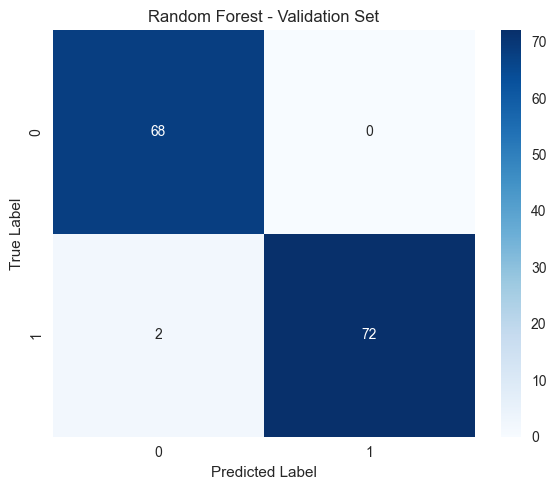

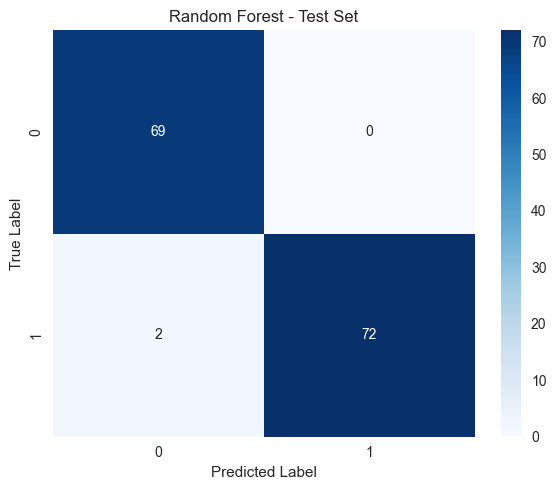

In [19]:
# Plot confusion matrices for best model
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

plot_confusion_matrix(y_val, y_pred_val, title=f'{best_model_name} - Validation Set')
plot_confusion_matrix(y_test, y_pred_test, title=f'{best_model_name} - Test Set')

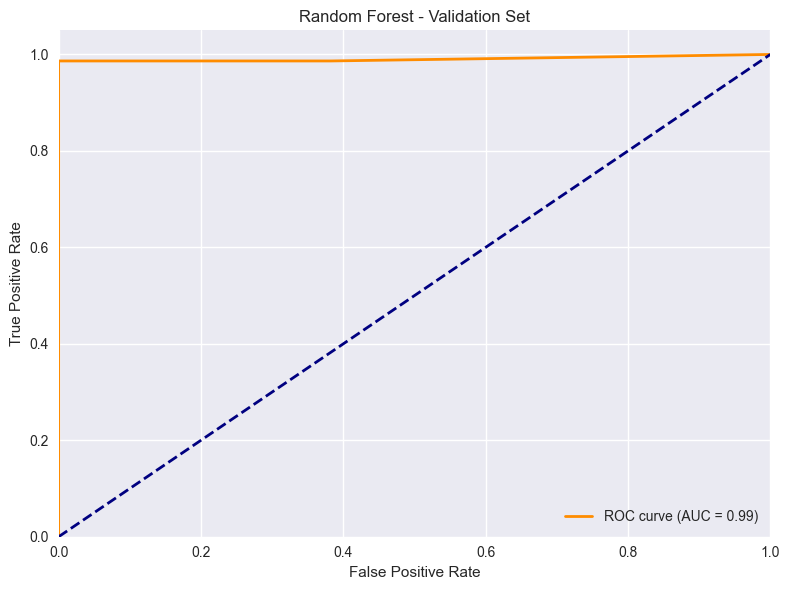

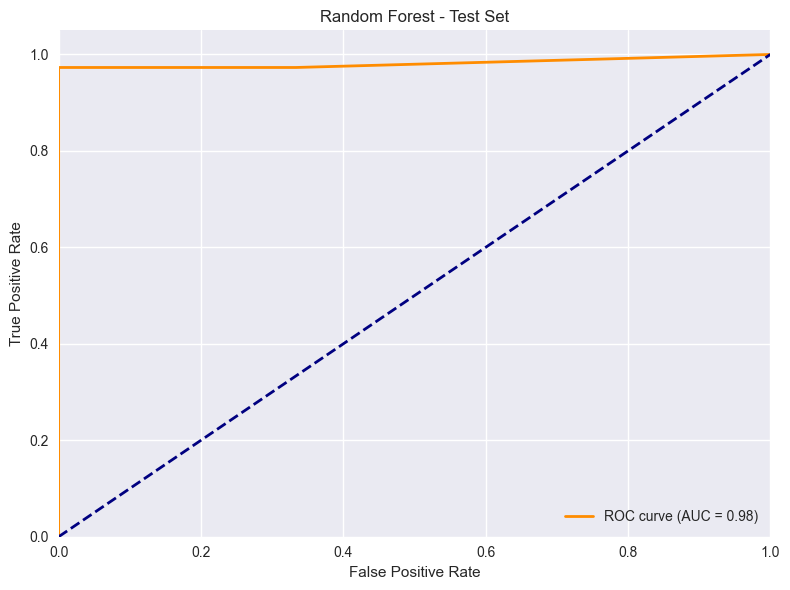

In [23]:
# Plot ROC curves
y_pred_proba_val = best_model.predict_proba(X_val)[:, 1]
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

plot_roc_curve(y_val, y_pred_proba_val, title=f'{best_model_name} - Validation Set')
plot_roc_curve(y_test, y_pred_proba_test, title=f'{best_model_name} - Test Set')

## 6. Feature Importance Analysis

Analyze which features are most important for prediction,

In [24]:
# Analyze feature importance for the best model
feature_importance = analyze_feature_importance(best_model, numeric_features)
print("\nFeature Importance:\n")
display(feature_importance)

# Plot feature importance
plot_feature_importance(best_model, numeric_features)


Feature Importance:



,feature,importance
3,Last_Week_Price_Change,0.143063
9,Last_3Months_Price_Change,0.101944
11,Last_3Months_Volatility,0.096438
8,Last_Month_Volatility,0.087642
2,Latest_Est_Market_Cap,0.077895
7,Last_Month_Average,0.067968
1,Latest_Volume,0.066134
5,Last_Week_Volatility,0.065934
10,Last_3Months_Average,0.065473
4,Last_Week_Average,0.060159


ValueError: Model does not support feature importance plotting